# Psi method 

## Explination

The Psi method is an adaptive method to estimate the threshold and slope of a psychometric function using Bayesian estimation. Most of the concepts in this notebook is taken from Kontesevich and Tyler 1997 from Vision Research. 

The threshold of the psychometric function, denoted by $\alpha$, is the inflection point of the function, or the point at wich the response is 50/50 (in this specific case). It represents the bias in the estimates. The slope, denoted by $\beta$, reflects the uncertainty in the estimate.

The Psi method is an adaptive method in that the next stimulus is selected based on the previous response(s). This is in constrast to the method of constant stimuli which provides the same stimuli a pre-set number of times. Adaptive methods need to address three main considerations:
1. Estimate of psychometric parameters
2. The termination rule
3. Placement of the next trial

1. **Estimate the psychometric parameters ($\alpha$ and $\beta$)**

    The most efficient way to obtain these estimates is to use Bayesian estimation. First, we define the 2-d prior by making an initial guess for each of the parameters:
    
    $p(\alpha, \beta)$
    
    Then, after the response, $r$, we calculate the probability of all prior responses, given each set of parameter values:
    
    $p(r | \alpha, \beta)$
    
    Multiplying these distributions together yields the posterior distribution of all possible parameter values:
    
    $p(\alpha, \beta | r)$

    The mean of this distribution is the best estimate of the parameters because it minimizes the variance of the threshold and is more stable than using the maximum a posteri. 

    The posterior then becomes the prior for the next trial, and the process repeats until the test is terminated. 

2. **Termination rule**

    There are several different options, for simplicity, we plan on stopping after a certain number of trials

3. **Placement of the next trial**

    This is where the psi algorithm really does its work. To estimate threshold the most optimal location for the next stimulus is at the current threshold estimate, for the slope, it is slightly above and below the stimulus (in general). But, what specific stimulus should we choose? 
    
    Before each trial, the Psi algorithm simulates over every possible stimulus location for the next trial, $x$, calculating a posterior distribution for both possible responses at each $x$. Then, it calculates the Information Entropy ($H$) for each stimulus location ($H(x)$). The next stimulus is the one that minimizes the entropy" $\underset{x}{argmin}(H(x))$
    
    Information entropy is the amount of uncertainty in the distribution. Moving from an uncertain distribution to one with more certinaty increases the amount of infomration we can gain from one trial to the next. For example, the weather forcast in Newark, DE 7 days from now is 61 and cloudy. There is uncertainty in this prediction, but when that day comes, there will be no uncertainty. Therefore, we have gained information about the weather. 
    
    Information entroy is calculated as the probability times the log probability:
    
    $H = - \sum{p * log(p)}$

## Define Functions

### Look up table

First, we need to define a look-up table to speed up the method. This look-up table contains conditional probabilities of both possible responses given the parameter values and the stimulus location:

$p(r| \alpha,\beta,x)$

This probability is defined by:

$p(r=left | \alpha,\beta,x) = \Psi_{\alpha,\beta}(x)$

$p(r=right | \alpha,\beta,x) = 1-\Psi_{\alpha,\beta}(x)$

In [31]:
#Import python notebooks
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon
from scipy.stats import norm
from numpy.random import random
plt.rcParams['text.usetex'] = False
plt.rcParams.update({'font.size': 16})

In [45]:
def Psi_lookT(X,a_range,b_range):
    """
    This function creates two lookup tables required for the psi algorithm to run more efficiently
    It is a table of probabilities for both responses (left and right in this case) given all possible
    alpha and beta values and all possible stimulus locations:
    p(r='left'|alpha,beta,X)
    p(r='right'|alpha,beta,X)
    """
    #Set these nuisance parameters to nonzero values
    gam = 0.02
    lam = 0.02
    
    #Preallocate the lookup tables
    p_left_look = np.empty([len(b_range),len(a_range),(len(X))])
    p_right_look = np.empty([len(b_range),len(a_range),(len(X))])
    
    #Loop through all possible stimulus, alpha and beta values
    for x_i, x in enumerate(X):
        for a_i, a in enumerate(a_range):
            for b_i, b in enumerate(b_range):
                psi = gam + (1 - lam - gam) * norm.cdf(x,a,b)
                p_left_look[a_i,b_i,x_i] = psi
                p_right_look[a_i,b_i,x_i] = 1-psi

    return p_left_look, p_right_look

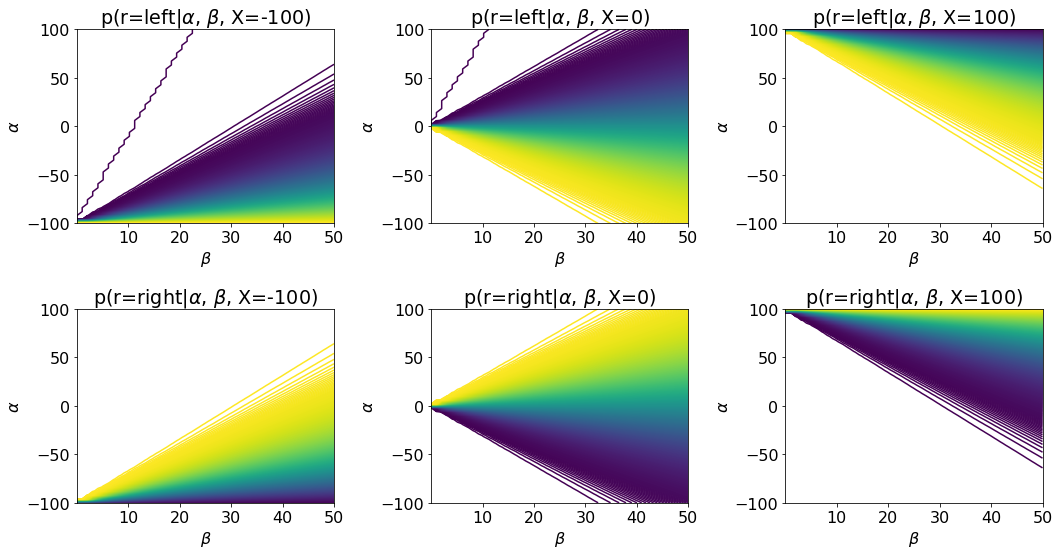

In [64]:
#Test to make sure this is working
#Set the ranges
X = np.arange(-100,110,10)
a_range = np.linspace(-100,100)
b_range = np.linspace(0.001,50)

#Run the function
p_left_look, p_right_look = Psi_lookT(X,a_range,b_range)

#Plot
fig, ax = plt.subplots(2, 3,figsize=(15,8),tight_layout=True)
ax[0,0].contour(b_range,a_range,p_left_look[:,:,0],1000)
ax[0,0].set(title=r'p(r=left|$\alpha$, $\beta$, X=-100)',xlabel=r'$\beta$',ylabel=r'$\alpha$')
ax[0,1].contour(b_range,a_range,p_left_look[:,:,10],1000)
ax[0,1].set(title=r'p(r=left|$\alpha$, $\beta$, X=0)',xlabel=r'$\beta$',ylabel=r'$\alpha$')
ax[0,2].contour(b_range,a_range,p_left_look[:,:,-1],1000)
ax[0,2].set(title=r'p(r=left|$\alpha$, $\beta$, X=100)',xlabel=r'$\beta$',ylabel=r'$\alpha$')

ax[1,0].contour(b_range,a_range,p_right_look[:,:,0],1000)
ax[1,0].set(title=r'p(r=right|$\alpha$, $\beta$, X=-100)',xlabel=r'$\beta$',ylabel=r'$\alpha$')
ax[1,1].contour(b_range,a_range,p_right_look[:,:,10],1000)
ax[1,1].set(title=r'p(r=right|$\alpha$, $\beta$, X=0)',xlabel=r'$\beta$',ylabel=r'$\alpha$')
ax[1,2].contour(b_range,a_range,p_right_look[:,:,-1],1000)
ax[1,2].set(title=r'p(r=right|$\alpha$, $\beta$, X=100)',xlabel=r'$\beta$',ylabel=r'$\alpha$')
plt.show()

**Explination:**

The lookup tables are essentially simulations of each response option given all possible world states (alpha, beta, X-stim values). Specifically they are 3d tables of probabilities for each response (left and right) given all possible alphas, betas, and stimulus positions. Plotted above are examples of different probability distributions for specific stimulus positions. 

For example, in the top middle plot we have the probability of the response being "left" given all possible alpha and beta values at the stimulus position X=0. If a person responds 'left' at the stimulus value X=0, it is more likely that their threshold (alpha) is below 0 (imagine the psychometric function with a negative threshold). The opposite is true fo r='right' (bottom middle). Note this does not give us much information about the beta values because we are dealing with just the single trial. 

Now lets take the extreme example of a stimulus at X=-100 (first column) and the response is left (top left). First of all, this is a very unlikley response and indiates the most likely threshold is less than -100. It is much more likely for the response to be "right" at this extreme stimulus, so it does not give us much information about the threshold. 

Similar logic can be used for the opposite extreme case of X=100 (3rd column). 

### Entropy function

Here we calculate the entropy for each possible stimulus value, x

In [171]:
#Entropy function
def CalcH(X, p_left_look, p_right_look, Prior):

    """
    This function calculates the entropy (H) of each possible stimulus value to determine which one minimizes,
    the entropy for the next trial. This is the stimulus that will provide the most information for both parameters
    """
    
    #Simulate through each possible stim value, X
    EH = []
    for i, x in enumerate(X):

        #Calculate the probability of getting a response, r, after presenting test x at the next trial (across all possible parameter values)
        p_left = np.nansum(np.nansum(np.multiply(p_left_look[:,:,i],Prior)))
        p_right = np.nansum(np.nansum(np.multiply(p_right_look[:,:,i],Prior)))

        #Calculate the posterior for each response 
        Post_left = np.multiply(Prior,p_left_look[:,:,i])
        Post_left = np.divide(Post_left, np.nansum(np.nansum(Post_left)))
        Post_right = np.multiply(Prior,p_right_look[:,:,i])
        Post_right = np.divide(Post_right, np.nansum(np.nansum(Post_right)))

        #Estimate the entropy of the posterior distribution for each response
        H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
        H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))
        
        #Combine the entropy calculations, weighted by their probabilities
        Total_H = (H_left*p_left) + (H_right*p_right)
        EH.append(Total_H)
    
    EH = np.array(EH)
    return EH

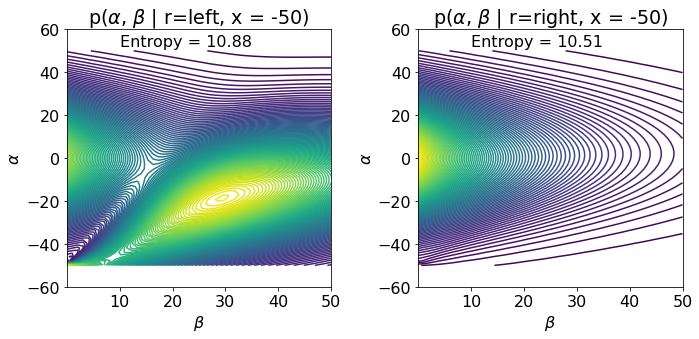

p_left = 0.05; p_right = 0.95
Total Entroy at X=-50: 10.53


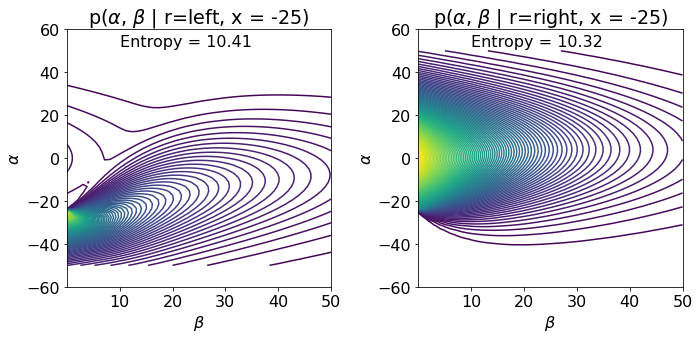

p_left = 0.18; p_right = 0.82
Total Entroy at X=-25: 10.33


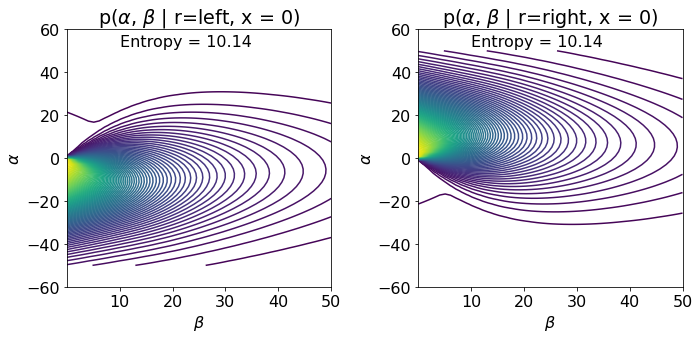

p_left = 0.5; p_right = 0.5
Total Entroy at X=0: 10.14


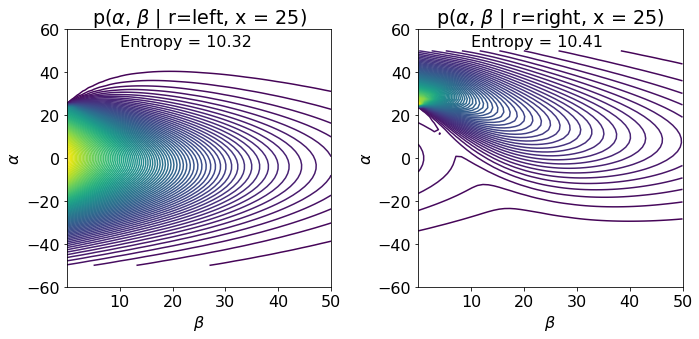

p_left = 0.82; p_right = 0.18
Total Entroy at X=25: 10.33


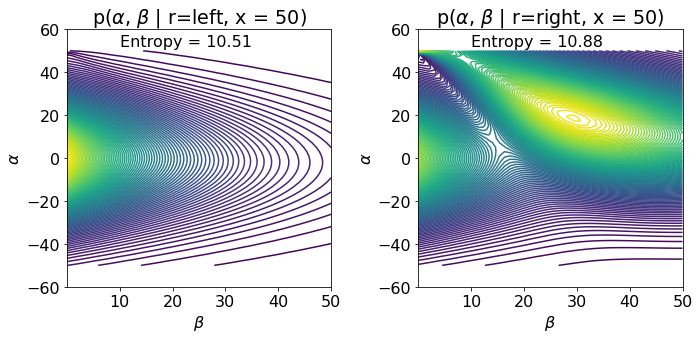

p_left = 0.95; p_right = 0.05
Total Entroy at X=50: 10.53


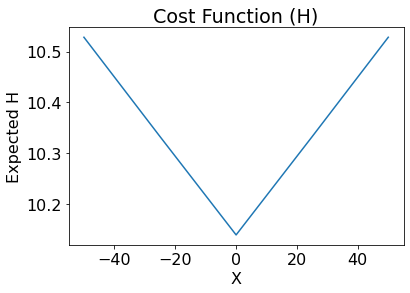

In [145]:
#Test to make sure this entropy function is working:

#Ranges
X = np.arange(-50,75,25)
a_range = np.linspace(-50,50)
b_range = np.linspace(0.001,50)
p_left_look, p_right_look = Psi_lookT(X,a_range,b_range)

#Set the priors
p_alpha = norm.pdf(a_range,0,20)
p_beta = expon.pdf(b_range,0,20)
p_alpha = np.reshape(p_alpha,(len(p_alpha),1))
p_beta = np.reshape(p_beta,(len(p_beta),1))
#Create the 2d prior and make sure it sums to 1
Prior = p_alpha @ p_beta.T
Prior = Prior/np.nansum(np.nansum(Prior))

#Entropy function -----------------------------------
#Simulate through each possible stim value, X
EH = []
for i, x in enumerate(X):
    
    #Calculate the probability of getting a response, r, after presenting test x at the next trial (across all possible parameter values)
    p_left = np.nansum(np.nansum(np.multiply(p_left_look[:,:,i],Prior)))
    p_right = np.nansum(np.nansum(np.multiply(p_right_look[:,:,i],Prior)))
        
    #Calculate the posterior for each response 
    Post_left = np.multiply(Prior,p_left_look[:,:,i])
    Post_left = np.divide(Post_left, np.nansum(np.nansum(Post_left)))
    Post_right = np.multiply(Prior,p_right_look[:,:,i])
    Post_right = np.divide(Post_right, np.nansum(np.nansum(Post_right)))
    
    #Estimate the entropy of the posterior distribution for each response
    H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
    H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))

    #Combine the entropy calculations, weighted by their probabilities
    Total_H = (H_left*p_left) + (H_right*p_right)
    EH.append(Total_H)

    #Plot
    fig, ax = plt.subplots(1, 2, figsize=(10,5),tight_layout=True)
    ax[0].contour(b_range,a_range,Post_left,100)
    ax[0].text(10,52, 'Entropy = '+str(round(H_left,2)))
    ax[0].set(title=r'p($\alpha$, $\beta$ | r=left, x = '+str(x)+')' ,xlabel=r'$\beta$',ylabel=r'$\alpha$',ylim=(-60, 60))
    ax[1].contour(b_range,a_range,Post_right,100)
    ax[1].set(title=r'p($\alpha$, $\beta$ | r=right, x = '+str(x)+')' ,xlabel=r'$\beta$',ylabel=r'$\alpha$',ylim=(-60, 60))
    ax[1].text(10,52, 'Entropy = '+str(round(H_right,2)))
    plt.show()    
    
    print('p_left = ' + str(round(p_left,2)) + '; p_right = ' +str(round(p_right,2)) )
    print('Total Entroy at X=' + str(x) + ': ' + str(round(Total_H,2)))
    
EH = np.array(EH)
fig, ax = plt.subplots(1)
ax.plot(X,EH)
ax.set(xlabel='X',ylabel='Expected H',title='Cost Function (H)')
plt.show()

**Explination:**

Ok what are we looking at here? First, the purpose of this entropy calculation is to simulate one trial ahead to determine which stimulus value will provide the most information. Think of this type of entropy (information entropy) as the amount of uncertainty in a distribution. A wider distribution will have greater information entropy, while a narrower distribution will have less entropy. We are looking for the stimulus position with the highest certainty (lowest entropy) which will maximize the amount of information we can gain from that stimulus position. 

Lets take the first *simulated* stimulus position, X=-50 in the first row of plots. We are looking at posterior probability distributions for our possible alpha and beta values. This posterior distribution is the combination of the prior probability distribution, $p(\alpha,\beta)$, and the probability of the responses given each parameter and the stimulus value, $p(r=left | \alpha, \beta, X=-50)$ and $p(r=right | \alpha, \beta, X=-50)$. If the stimulus is set at -50 for the next trial (the left foot is well behind the right) but the response is still left (left plot), the resulting distribution suggests that the threshold (alpha) is most likely around -50 or lower or less than that but very uncertain. Note that there is a small blip of higher probability around 0 which is from the prior. This resulting distribution is relatively more uncertain than the distribution if the response was right (not the higher entropy). The total entropy at X=-50 (printed below the plot), is the weighted combination of the entropy of both posterior probability distributions. In other words, the left and right posterior probability distributions are weighted by the probability of each response given all alpha and beta values at the current stimulus X=-50, denoted by p_left and p_right. Hence, the total entropy for this stimulus value (10.53) is closer to the right distribuiton (10.51) which makes sense because the overall probability of a right response at x=-50 is much higher. 

The subsequent rows do the same thing for different stimulus positions. Notice that the stimulus position that minimizes entropy is 0 for the first trial. This is because the prior we set is centered on 0 for the threshold value (last plot).

So how can we 'kick the tires' on the entropy calculation to make sure it is doing what we want it to? Well, lets say that both responses are equally probable at all possible alpha and beta values (unrealistic but works for our purpose). This prevents the simulated subsequent response from playing a role in the entropy calculation. So now the only input to the system is the prior. We can plug in different priors, changing the one with the lowest sigma. The prior with the lowest SD should be the one selected for the minimum entropy. Lets see if this is the case:

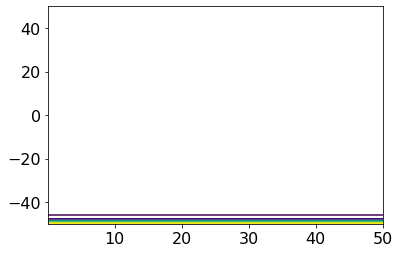

In [202]:
#Kick the tires

#Set the priors
p_alpha = norm.pdf(a_range,p,20)
p_alpha = np.reshape(p_alpha,(len(p_alpha),1))
p_beta = expon.pdf(b_range,0,20)
p_beta = np.reshape(p_beta,(len(p_beta),1))
Prior = p_alpha @ p_beta.T
Prior = Prior/np.nansum(np.nansum(Prior))
    
#Ranges
X = np.arange(-50,75,25)
a_range = np.linspace(-50,50)
b_range = np.linspace(0.001,50)

#Need new lookup tables with 50/50 everywhere
p_left_look = np.empty([len(b_range),len(a_range),(len(X))])
p_right_look = np.empty([len(b_range),len(a_range),(len(X))])
#Loop through all possible stimuli, alpha, and beta values
for x_i, x in enumerate(X):
    for a_i, a in enumerate(a_range):
        for b_i, b in enumerate(b_range):
            psi = norm.cdf(x,a,0.1)
            p_left_look[a_i,b_i,x_i] = psi
            p_right_look[a_i,b_i,x_i] = 1-psi
            
plt.contour(b_range,a_range,p_left_look[:,:,0],100)         
# for p in X:
#     print(p)

    
#     EH = CalcH(X, p_left_look, p_right_look, Prior)

    
    #Index the min entropy value
#     EH = np.array(EH)
#     best_stim = X[np.argmin(EH)]
#     print(best_stim)
#     plt.figure()
#     plt.plot(X,EH)
# #     print(X[np.argmin(EH)])

### Psi simulation function

Here we define the psi function 

In [66]:
def PSIsim(Ntrials, params, X, a_range, b_range, Prior, p_left_look, p_right_look):
    
    """
    Simulate the Psi algorithm with the number of trials and the given parameters (params),
    Need to also input the range of possible alpha and beta values, the prior and the lookup tables
    """

    #Define the parameters
    alpha = params[0]
    beta = params[1]
    lam = params[2]
    gam = params[3]
    
    #initialize 
    stims = np.empty(Ntrials)
    responses = np.empty(Ntrials)
    alpha_EV = np.empty(Ntrials)
    beta_EV = np.empty(Ntrials)
    
    #Start the experiment
    for t in range(Ntrials):
        print(t)
        
        #First simulate through each possible stim value, X, and calculate entropy
        H = CalcH(X, p_left_look, p_right_look, Prior)
        stim = X[np.argmin(H)]
        stims.append(stim)
        plt.figure()
        plt.plot(X,H)
        print(stims[t])
        
        #Participant makes a selection
        P_left = gam + (1 - lam - gam)*norm.cdf(stims[t],alpha,beta)
        responses[t] = P_left > np.random.rand()
        print(responses[t])
        
        #Account for repeated stimuli 
        Unique_stims, stim_idx = np.unique(stims, return_index=True)
        Unique_stims = stims[np.sort(stim_idx)]
        Nstims = np.empty(len(Unique_stims))
        Kleft = np.empty(len(Unique_stims))
        for u, s in enumerate(Unique_stims):
            stim_idx = np.argwhere(s==stims)
            stim_idx = stim_idx[:,0]
            Nstims[u] = len(stim_idx)
            Kleft[u] = np.sum(responses[stim_idx]) 
            
        #Calcualte the likelihood for the response given the current parameters
        Likelihood = np.empty((len(a_range),len(b_range)))
        for a_i, a in enumerate(a_range):
            for b_i, b in enumerate(b_range):
                psi = gam + (1 - lam - gam)*norm.cdf(Unique_stims,a,b)
                Likelihood[a_i,b_i] = np.prod((psi**Kleft) * ((1-psi)**(Nstims-Kleft)))
        
        #Calculate the posterior
        Posterior = Likelihood*Prior
        Posterior = Posterior/np.nansum(np.nansum(Posterior))
        
        #Marginalize the posterior
        alpha_post = np.nansum(Posterior,axis=1)
        beta_post = np.nansum(Posterior,axis=0)
        
        #Calculate the expected value of each
        alpha_EV[t] = np.nansum(a_range*alpha_post) 
        beta_EV[t] = np.nansum(b_range*beta_post)
        
        #The posterior becomes the prior for the next trial
        Prior = Posterior
        
    return alpha_EV, beta_EV, stims, responses, Posterior

In [221]:
#Test to see the fits 
Ntrials = 20 #trials per stimulus level

#Set the priors
p_alpha = norm.pdf(a_range,p,20)
p_alpha = np.reshape(p_alpha,(len(p_alpha),1))
p_beta = expon.pdf(b_range,0,20)
p_beta = np.reshape(p_beta,(len(p_beta),1))
Prior = p_alpha @ p_beta.T
Prior = Prior/np.nansum(np.nansum(Prior))
    
#We will feed in stimuli 
X = np.arange(-100,110,10)
a_range = np.linspace(-50,50)
b_range = np.linspace(0.001,50)

alpha_sim = norm.rvs(0,20)
beta_sim = expon.rvs(20)

#Randomize stimuli
All_stims = []
for n in range(Ntrials):
    All_stims = np.append(All_stims,np.random.permutation(X))

stims = []
responses = []
alpha_EV = []
beta_EV = []

#Loop through all trials
for s, i in enumerate(All_stims):
       
    stims = np.append(stims,All_stims[s])
    
    #Simulate participant
    p_left = norm.cdf(All_stims[s],alpha_sim,beta_sim)
    responses = np.append(responses,p_left > np.random.rand())
    
    #Account for repeated stimuli 
    Unique_stims, stim_idx = np.unique(stims, return_index=True)
    Unique_stims = stims[np.sort(stim_idx)]
    Nstims = np.empty(len(Unique_stims))
    Kleft = np.empty(len(Unique_stims))
    for u, s in enumerate(Unique_stims):
        stim_idx = np.argwhere(s==stims)
        stim_idx = stim_idx[:,0]
        Nstims[u] = len(stim_idx)
        Kleft[u] = np.sum(responses[stim_idx]) 
        
    #Calcualte the likelihood for the response given the current parameters
    Likelihood = np.empty((len(a_range),len(b_range)))
    for a_i, a in enumerate(a_range):
        for b_i, b in enumerate(b_range):
            psi = norm.cdf(Unique_stims,a,b)
            Likelihood[a_i,b_i] = np.prod((psi**Kleft) * ((1-psi)**(Nstims-Kleft)))

    #Calculate the posterior
    Posterior = Likelihood*Prior
    Posterior = Posterior/np.nansum(np.nansum(Posterior))

    #Marginalize the posterior
    alpha_post = np.nansum(Posterior,axis=1)
    beta_post = np.nansum(Posterior,axis=0)

    #Calculate the expected value of each
    alpha_EV = np.append(alpha_EV,np.nansum(a_range*alpha_post))
    beta_EV = np.append(beta_EV,np.nansum(b_range*beta_post))

    #The posterior becomes the prior for the next trial
    Prior = Posterior  
    
alpha_EV

array([ 22.82076725,   8.75697345,   1.92899364,   0.09531234,
        -0.6076762 ,  -0.92414386,  -1.11224986,  -1.23623009,
        -1.32361428,  -1.38787886,  -1.43632632,  -1.47355939,
       -18.60113426, -21.46257934, -23.00159561, -16.94934026,
       -15.74856774, -15.03898168, -15.07787366, -15.11869251,
       -15.03504869, -14.96857983, -14.90183791, -14.84339816,
       -14.79419779, -14.75212981, -14.71569215, -14.68826473,
       -14.66423989, -14.95996466, -15.21493368, -15.47308586,
       -15.60150547, -15.72460527, -15.81607035, -15.89794141,
       -15.93409387, -16.07293534, -16.19660114, -16.30761595,
       -16.40788732, -16.53999211, -16.51569388, -16.49379248,
       -16.47498303, -16.45779833, -16.6073295 , -16.77198847,
       -16.92107717, -17.05586749, -17.18127951, -17.29506357,
       -17.39196702, -17.48003322, -17.56031252, -17.63390006,
       -17.70163622, -17.76441094, -17.82961449, -17.87639176,
       -17.92036779, -17.96041879, -17.95093334, -17.93

In [ ]:
fig, ax = subplots(1)
ax.plot()
All_stims

## Simulate

### Single participant simulation

In [58]:
#Define the stimulus range
X = np.arange(-50,51)
a_range = np.arange(-50,51)
b_range = np.arange(0,101)

In [59]:
#Create the lookup tables
p_left_look, p_right_look = Psi_lookT(X,a_range,b_range)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1953: RuntimeWarning: invalid value encountered in long_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1953: RuntimeWarning: divide by zero encountered in long_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)


Sum of prior =  1.0


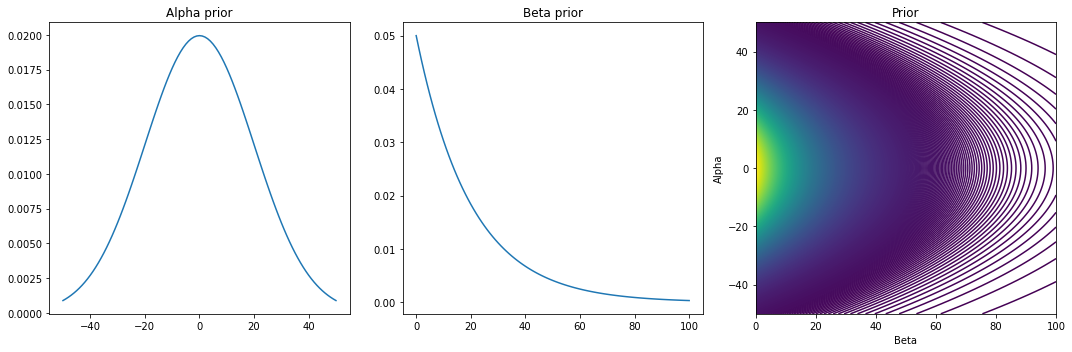

In [18]:
#Set the priors
p_alpha = norm.pdf(a_range,0,20)
p_beta = expon.pdf(b_range,0,20)
p_alpha = np.reshape(p_alpha,(len(p_alpha),1))
p_beta = np.reshape(p_beta,(len(p_beta),1))

#Create the 2d prior and make sure it sums to 1
Prior = p_alpha @ p_beta.T
Prior = Prior/np.nansum(np.nansum(Prior))

print('Sum of prior = ', sum(sum(Prior)))

#Plot
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(a_range,p_alpha)
plt.title('Alpha prior')
plt.subplot(1,3,2)
plt.plot(b_range,p_beta)
plt.title('Beta prior')
plt.subplot(1,3,3)
plt.contour(b_range,a_range,Prior,1000)
plt.title('Prior')
plt.ylabel('Alpha')
plt.xlabel('Beta')
plt.tight_layout()
plt.show()

0
-8.0
0.0


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1953: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1953: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


1
-8.0
0.0


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1953: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1953: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


2
18.0
1.0


C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:24: RuntimeWarning: divide by zero encountered in log2
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:24: RuntimeWarning: invalid value encountered in multiply
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:25: RuntimeWarning: divide by zero encountered in log2
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:25: RuntimeWarning: invalid value encountered in multiply
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1953: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:

3
18.0
1.0


C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:24: RuntimeWarning: divide by zero encountered in log2
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:24: RuntimeWarning: invalid value encountered in multiply
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:25: RuntimeWarning: divide by zero encountered in log2
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:25: RuntimeWarning: invalid value encountered in multiply
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1953: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:

4
18.0
1.0


C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:24: RuntimeWarning: divide by zero encountered in log2
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:24: RuntimeWarning: invalid value encountered in multiply
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:25: RuntimeWarning: divide by zero encountered in log2
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:25: RuntimeWarning: invalid value encountered in multiply
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1953: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:

5
18.0
1.0


C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:24: RuntimeWarning: divide by zero encountered in log2
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:24: RuntimeWarning: invalid value encountered in multiply
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:25: RuntimeWarning: divide by zero encountered in log2
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:25: RuntimeWarning: invalid value encountered in multiply
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1953: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:

6
18.0
1.0


C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:24: RuntimeWarning: divide by zero encountered in log2
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:24: RuntimeWarning: invalid value encountered in multiply
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:25: RuntimeWarning: divide by zero encountered in log2
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:25: RuntimeWarning: invalid value encountered in multiply
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1953: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:

7
18.0
1.0


C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:24: RuntimeWarning: divide by zero encountered in log2
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:24: RuntimeWarning: invalid value encountered in multiply
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:25: RuntimeWarning: divide by zero encountered in log2
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:25: RuntimeWarning: invalid value encountered in multiply
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1953: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:

8
18.0
1.0


C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:24: RuntimeWarning: divide by zero encountered in log2
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:24: RuntimeWarning: invalid value encountered in multiply
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:25: RuntimeWarning: divide by zero encountered in log2
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:25: RuntimeWarning: invalid value encountered in multiply
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1953: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:

9
18.0
1.0


C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:24: RuntimeWarning: divide by zero encountered in log2
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:24: RuntimeWarning: invalid value encountered in multiply
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:25: RuntimeWarning: divide by zero encountered in log2
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_16192/1137691760.py:25: RuntimeWarning: invalid value encountered in multiply
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1953: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:

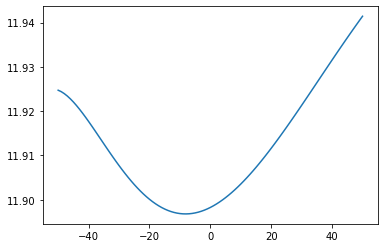

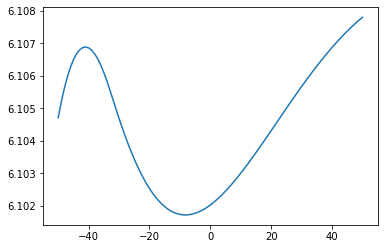

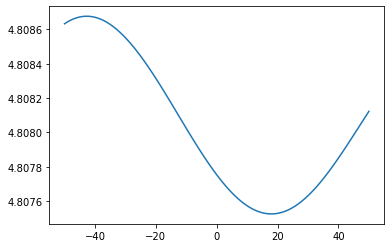

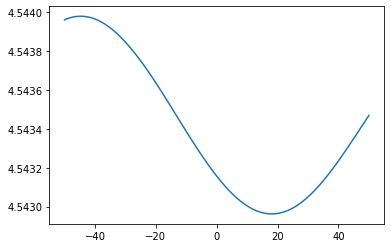

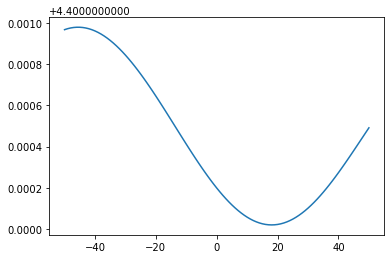

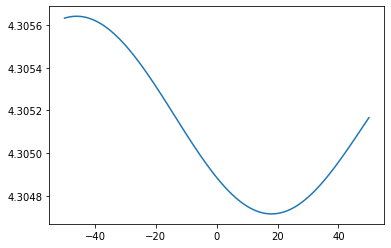

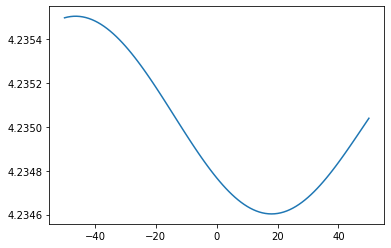

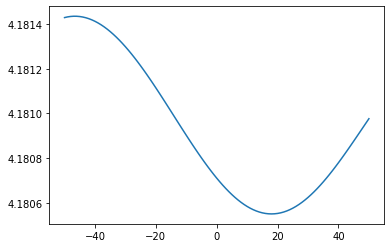

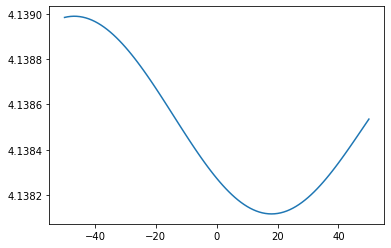

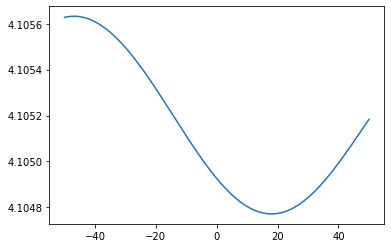

In [63]:
#Set some values for the expeirment
Ntrials = 10
#Set the parameters
alpha_sim = norm.rvs(0,10)
beta_sim = expon.rvs(0.01,20)
params = [alpha_sim,
          beta_sim, 
          0.02, 
          0.02]

#Stimulate
alpha_EV, beta_EV, stims, responses, Posterior = PSIsim(Ntrials, params, X, a_range, b_range, Prior, p_left_look, p_right_look)

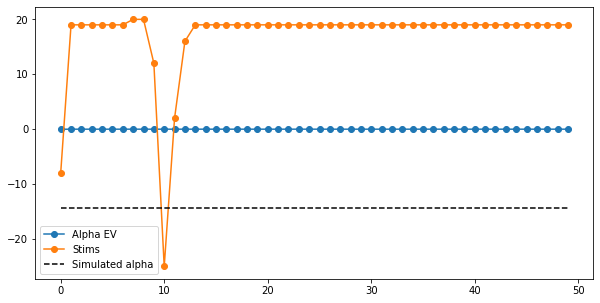

In [21]:
#Plot
plt.figure(figsize=(10,5))
plt.plot(alpha_EV,'o-',label='Alpha EV')
plt.plot(stims,'o-',label='Stims')
plt.plot(np.ones(len(alpha_EV))*alpha_sim,'k--',label='Simulated alpha')
plt.legend()
plt.show()

Locator attempting to generate 1001 ticks ([0.0, ..., 1.0]), which exceeds Locator.MAXTICKS (1000).


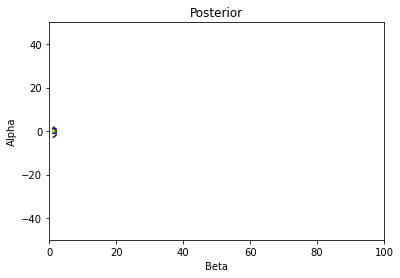

In [22]:
plt.contour(b_range,a_range,Posterior,1000)
plt.title('Posterior')
plt.ylabel('Alpha')
plt.xlabel('Beta')
plt.show()

In [33]:
EA = np.empty(10)
sum(EA)

0.0